# Quantization maths

There are multiple quantization techniques. Each technique has its pros and cons. The intent of this notebook is to show you how quantization (math) works under the covers. 

[Affine quantization]

### Utility function to plot bar charts
Charts the original FP32 and INT8, INT4 uantized values in multi-bar graph for comparison purposes

In [1]:
import matplotlib.pyplot as plt
import numpy as np

       
def plot_quantizations(original, dequantized_32, dequantized_8, dequantized_4):

    x = np.arange(len(original))

    width = 0.2
    
    # Create the plot
    fig, ax = plt.subplots()

    # Plotting the bars for each array with offsets to group them
    bars1 = ax.bar(x - width, original, width, label='Original', color='b')
    bars2 = ax.bar(x, dequantized_8, width, label='INT8', color='g')
    bars3 = ax.bar(x + width, dequantized_4, width, label='INT4', color='r')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('De-Quantized')
    ax.set_title('Loss comparison ')

    ax.set_xticks(x)
    ax.set_xticklabels(original.astype(str))
    ax.set_xlabel('Original')
    
    ax.legend()

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

# Affine quantization

Affine quantization is a very flexible technique that can potentially achieve better accuracy than *Uniform* quantization technique covered later, but it requires more computation to determine the optimal scaling parameters.

* Uses a **scaling factor** and **offset** (zero point) for each value in the input array.
* The scaling factor is calculated based on the quantization range and the offset.
* The offset is added to the input values before scaling and subtracted from the quantized values after scaling.

This additional flexibility in affine quantization allows it to better adapt to the distribution of values in the input array, potentially improving accuracy for some models. However, it also requires additional computational overhead during inference.

In [2]:
# Function shows how an array of FP32 numbers are converted to INT of specified size (in bits)
def affine_quantize(array, num_bits):
    
    # Determine the range of the array
    min_val, max_val = np.min(array), np.max(array)
    
    # Calculate the number of quantization levels
    q_levels = 2 ** num_bits  # Number of quantization levels

    # Calculate the scale (step size) and zero-point (shift)
    scale = (max_val - min_val) / (q_levels - 1)

    # Same as offset
    zero_point = np.round(-min_val / scale)
    
    # Apply affine quantization
    quantized_array = np.round((array / scale) + zero_point)
    
    # Dequantize to map back to original value range for display / comparison
    dequantized_array = (quantized_array - zero_point) * scale

    # Return the quantized and dequantized arrays
    return quantized_array, dequantized_array

32 bit :  [-0.6 -0.2  0.1  0.4  0.5  0.7]
8  bit :  [-0.60156863 -0.19882353  0.10196078  0.39764706  0.49960784  0.69843137]
4  bit :  [-0.60666667 -0.17333333  0.08666667  0.43333333  0.52        0.69333333]


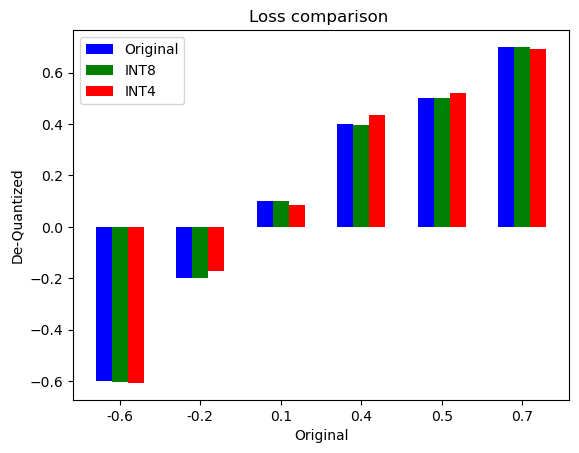

In [3]:
# Original array of FP32
original = np.array([-0.6, -0.2, 0.1, 0.4, 0.5, 0.7])

# 32 bit quantization
# Just to see if their is loss in original value due to quantization/dequantization
# Ideally we should not see any loss
x_quantized_32, x_dequantized_32 = affine_quantize(original, num_bits=32)
print("32 bit : ", x_dequantized_32)

# 8 bit quantization 
x_quantized_8, x_dequantized_8 = affine_quantize(original, num_bits=8)
print("8  bit : ", x_dequantized_8)

# 4 bit quantization 
x_quantized_4, x_dequantized_4 = affine_quantize(original, num_bits=4)
print("4  bit : ", x_dequantized_4)

plot_quantizations(original, x_dequantized_32, x_dequantized_8, x_dequantized_4)

# Uniform quantization

Uniform quantization is a simple and efficient approach but may introduce quantization errors.

* Uses a single scaling factor for all values in the input array.
* Does not use an offset (a.k.a. zero step)
* The quantization range is determined by the minimum and maximum values of the input array.

In [4]:


def uniform_quantize(array, num_bits):
    # Determine the range of the array
    min_val, max_val = np.min(array), np.max(array)
    
    # Calculate the quantization step size
    q_levels = 2 ** num_bits  # Number of quantization levels
    step_size = (max_val - min_val) / (q_levels - 1)
    
    # Apply uniform quantization
    quantized_array = np.round((array - min_val) / step_size)
    
    # Dequantize to map back to original value range
    dequantized_array = quantized_array * step_size + min_val
    
    return quantized_array, dequantized_array
    



### Quantize & De-Quantize
This is to show the loss of accuracy due to quantization

32 bit :  [-0.6 -0.2  0.1  0.4  0.5  0.7]
8  bit :  [-0.6        -0.20235294  0.09843137  0.39921569  0.50117647  0.7       ]
4  bit :  [-0.6        -0.16666667  0.09333333  0.44        0.52666667  0.7       ]


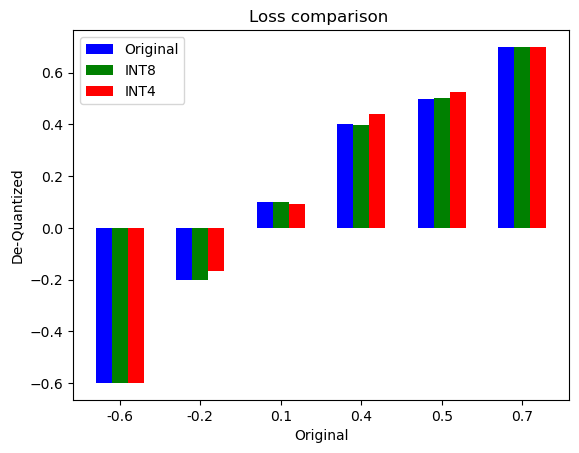

In [5]:
original = np.array([-0.6, -0.2, 0.1, 0.4, 0.5, 0.7])

# 32 bit quantization 
x_quantized_32, x_dequantized_32 = uniform_quantize(original, num_bits=32)
print("32 bit : ", x_dequantized_32)

# 8 bit quantization 
x_quantized_8, x_dequantized_8 = uniform_quantize(original, num_bits=8)
print("8  bit : ", x_dequantized_8)

# 4 bit quantization 
x_quantized_4, x_dequantized_4 = uniform_quantize(original, num_bits=4)
print("4  bit : ", x_dequantized_4)

plot_quantizations(original, x_dequantized_32, x_dequantized_8, x_dequantized_4)